# [놀이터] 비트코인 가격 예측하기

## 1. 개요

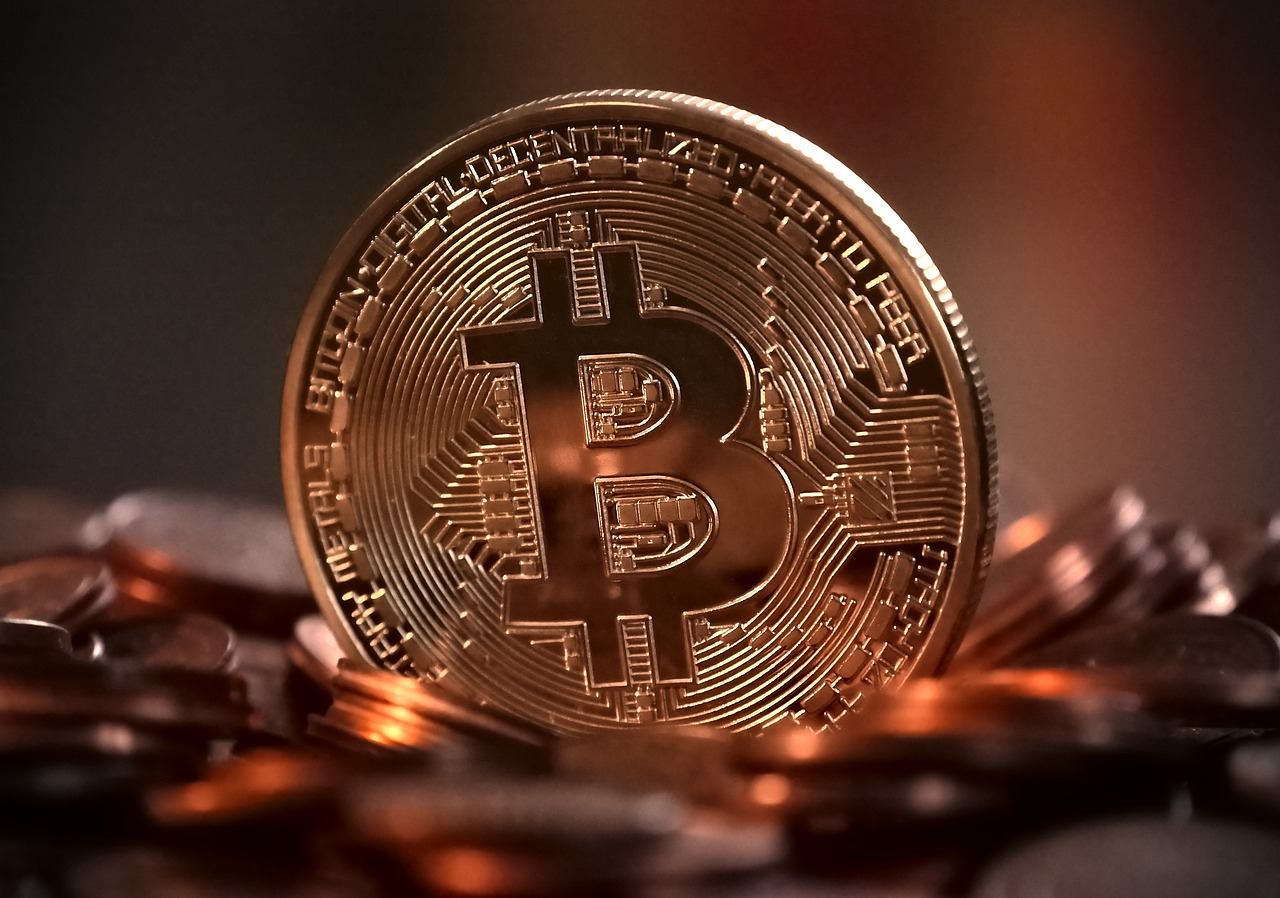

요즘 핫한 가상화폐 비트코인의 정보를 구한 뒤, 회귀분석을 통해 가격 예측을 해보겠습니다.

---
## 2. 데이터 준비 및 분석

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
binance = ccxt.binance()

In [3]:
btc_ohlcv_day = binance.fetch_ohlcv('BTC/USDT','1d') # 일봉 조회

df_day = pd.DataFrame(btc_ohlcv_day, columns = ['datetime','open','high','low','close','volume'])
df_day['datetime']=pd.to_datetime(df_day['datetime'], unit= 'ms') # 시간 단위를 년-월-일 시간으로 바꿈
df_day.set_index('datetime', inplace=True) # 인덱스는 시간으로 설정

print(df_day)

                open      high       low     close        volume
datetime                                                        
2022-08-10  23151.32  24226.00  22664.69  23954.05  208916.54953
2022-08-11  23954.05  24918.54  23852.13  23934.39  249759.79557
2022-08-12  23933.09  24456.50  23583.00  24403.68  174207.57040
2022-08-13  24401.70  24888.00  24291.22  24441.38  152852.25435
2022-08-14  24443.06  25047.56  24144.00  24305.24  151206.14473
...              ...       ...       ...       ...           ...
2023-12-18  41374.64  42757.81  40542.93  42657.80   46734.09250
2023-12-19  42657.80  43497.00  41811.10  42275.99   40927.86444
2023-12-20  42275.99  44283.00  42206.00  43668.93   48710.29470
2023-12-21  43668.92  44242.35  43286.72  43861.80   34624.29384
2023-12-22  43861.79  44251.00  43722.46  44145.00    6014.24410

[500 rows x 5 columns]


### 데이터 사전

+ **Open** - 봉의 기간 중 처음 거래 가격
+ **High** - 봉의 기간 중 가장 높은 가격
+ **Low** - 봉의 기간 중 가장 낮은 가격
+ **Close** - 봉의 기간 중 마지막 거래 가격
+ **Volume** - 봉 하나의 거래량

In [4]:
import mplfinance as mpf # 증권 그래프 그리는 라이브러리

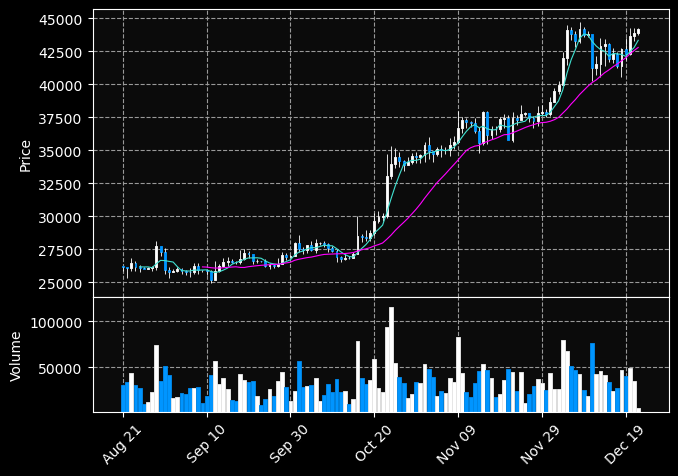

In [5]:
mpf.plot(df_day['2023-08-21':'2023-12-22'], # 23.08.21 ~ 23.12.22 까지 거래만 표시
         type='candle',
         style='nightclouds',
         mav = (5,20), # 5일, 20일 이동평균선
         volume = True) # 그래프 하단에 거래량 표시

거래량이 많을 수록 그래프의 움직임이 크다는 것을 확인할 수 있습니다.

---

# 3. 머신러닝

In [6]:
Op=np.array(df_day["open"])
Hi=np.array(df_day["high"])
Lo=np.array(df_day["low"])
Cl=np.array(df_day["close"])
V=np.array(df_day["volume"])

In [7]:
input=np.column_stack((Op,Hi,Lo,V))
output=Cl

저희가 구하고자 하는 가격은 마지막 거래 가격인 'close'로 하겠습니다.

In [9]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
input_scaled=SS.fit_transform(input) # 데이터 스케일링

In [10]:
from sklearn.model_selection import train_test_split
train_input,test_input,train_output,test_output=train_test_split(input_scaled,output) # 데이터셋 분할

In [11]:
from xgboost import XGBRegressor, plot_importance

XGBR=XGBRegressor(max_depth=3, reg_alpha=0.1)
XGBR.fit(train_input,train_output) #머신러닝

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## 평가

In [12]:
XGBR.score(test_input,test_output)

0.9938272455123331

[Text(0, 0, 'open'),
 Text(0, 1, 'high'),
 Text(0, 2, 'low'),
 Text(0, 3, 'volume')]

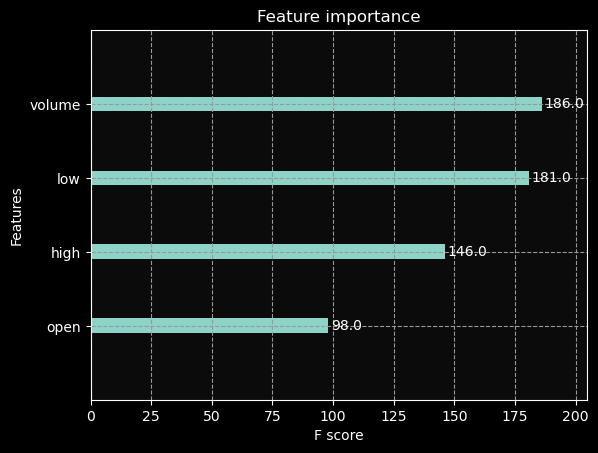

In [13]:
plot_importance(XGBR).set_yticklabels(['open','high','low','volume'])

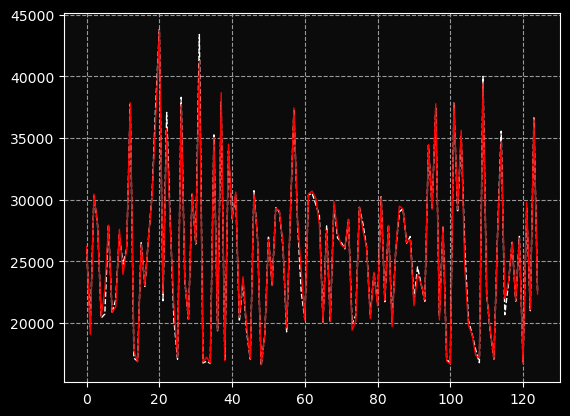

In [14]:
plt.plot(XGBR.predict(test_input),'w--')
plt.plot(test_output,'r')